In [1]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

2024-06-18 07:40:49.533615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 07:40:49.533723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 07:40:49.696211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Creating the Pathlib PATH objects
train_path =Path("/kaggle/input/face-expression-recognition-dataset/images/train")
test_path =Path("/kaggle/input/face-expression-recognition-dataset/images/validation")

In [3]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/kaggle/input/face-expression-recognition-dataset/images/train/surprise/30778.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/22706.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/20513.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/27582.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/33678.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/6588.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/10213.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/30071.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/35390.jpg',
 '/kaggle/input/face-expression-recognition-dataset/images/train/surprise/4407.jpg']

In [4]:
# Getting their respective labels 
from sklearn.preprocessing import LabelEncoder 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))


Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

##convert it into vectorized way
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

In [5]:
##split the dataset
from sklearn.model_selection import train_test_split 
Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [6]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8020066889632107, 1: 16.18018018018018, 2: 1.7380645161290322, 3: 1.0, 4: 1.4507269789983845, 5: 1.4526826637907793, 6: 2.262914741705166}


In [7]:
 
# Function used for Transformation
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label




# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.05))
])



In [8]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [9]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.36 s, sys: 80.4 ms, total: 1.44 s
Wall time: 2.07 s
(32, 96, 96, 3)
(32, 7)


neutral


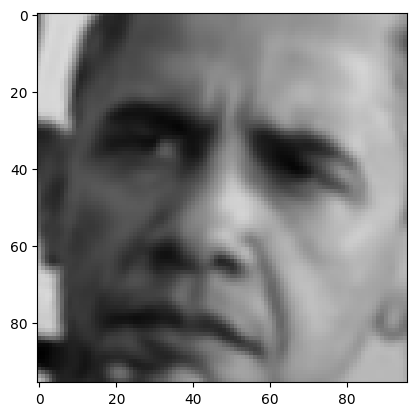

In [10]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [11]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 38.7 ms, sys: 128 µs, total: 38.8 ms
Wall time: 37.4 ms
(32, 96, 96, 3)
(32, 7)


neutral


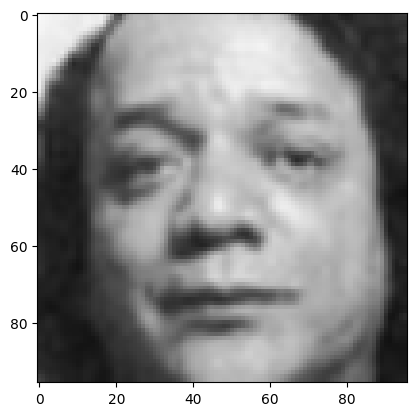

In [12]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [13]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ ?                      │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,768,569 (29.63 MB)

 Trainable params: 7,700,994 (29.38 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [14]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [15]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=40,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/40


I0000 00:00:1718696608.895175      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718696609.037746      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3180 - loss: 3.0557 - precision: 0.6008 - recall: 0.1100

W0000 00:00:1718696659.811356      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


675/675 ━━━━━━━━━━━━━━━━━━━━ 191s 84ms/step - accuracy: 0.3181 - loss: 3.0554 - precision: 0.6008 - recall: 0.1101 - val_accuracy: 0.4194 - val_loss: 1.5662 - val_precision: 0.6325 - val_recall: 0.2307
Epoch 2/40
  2/675 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.3596 - loss: 2.6573 - precision: 0.4079 - recall: 0.1638  

W0000 00:00:1718696751.324445      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4262 - loss: 2.6451 - precision: 0.6765 - recall: 0.2076

W0000 00:00:1718696799.456967      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


675/675 ━━━━━━━━━━━━━━━━━━━━ 137s 76ms/step - accuracy: 0.4262 - loss: 2.6450 - precision: 0.6765 - recall: 0.2076 - val_accuracy: 0.4844 - val_loss: 1.4423 - val_precision: 0.6582 - val_recall: 0.3192
Epoch 3/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.4816 - loss: 2.4009 - precision: 0.6961 - recall: 0.2724 - val_accuracy: 0.4933 - val_loss: 1.3056 - val_precision: 0.6869 - val_recall: 0.3235
Epoch 4/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.5105 - loss: 2.2619 - precision: 0.7153 - recall: 0.3037 - val_accuracy: 0.4476 - val_loss: 1.4539 - val_precision: 0.5492 - val_recall: 0.3044
Epoch 5/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.5070 - loss: 2.2422 - precision: 0.7053 - recall: 0.3075 - val_accuracy: 0.5137 - val_loss: 1.2936 - val_precision: 0.6807 - val_recall: 0.3287
Epoch 6/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - accuracy: 0.5431 - loss: 2.1033 - precision: 0.7200 - recall: 0.3423 - val_accuracy: 0.5673 - val_loss: 1.

In [16]:
model.layers[0].trainable = False

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 3, 3, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,763,860 (90.65 MB)

 Trainable params: 197,767 (772.53 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 15,797,524 (60.26 MB)

In [18]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=10,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)
    

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7408 - loss: 1.1409 - precision: 0.8153 - recall: 0.6604
Epoch 1: val_loss improved from inf to 1.18896, saving model to best_weights.weights.h5
675/675 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.7407 - loss: 1.1410 - precision: 0.8153 - recall: 0.6604 - val_accuracy: 0.5747 - val_loss: 1.1890 - val_precision: 0.6715 - val_recall: 0.4735
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7087 - loss: 1.2620 - precision: 0.7942 - recall: 0.6158
Epoch 2: val_loss improved from 1.18896 to 1.14518, saving model to best_weights.weights.h5
675/675 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.7087 - loss: 1.2619 - precision: 0.7942 - recall: 0.6159 - val_accuracy: 0.6295 - val_loss: 1.1452 - val_precision: 0.6934 - val_recall: 0.5757
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7354 - loss: 1.1308 - precision: 0.8114 - recall: 0.6570
Epoch 3: val_loss improved from 1.14518 to 1.0

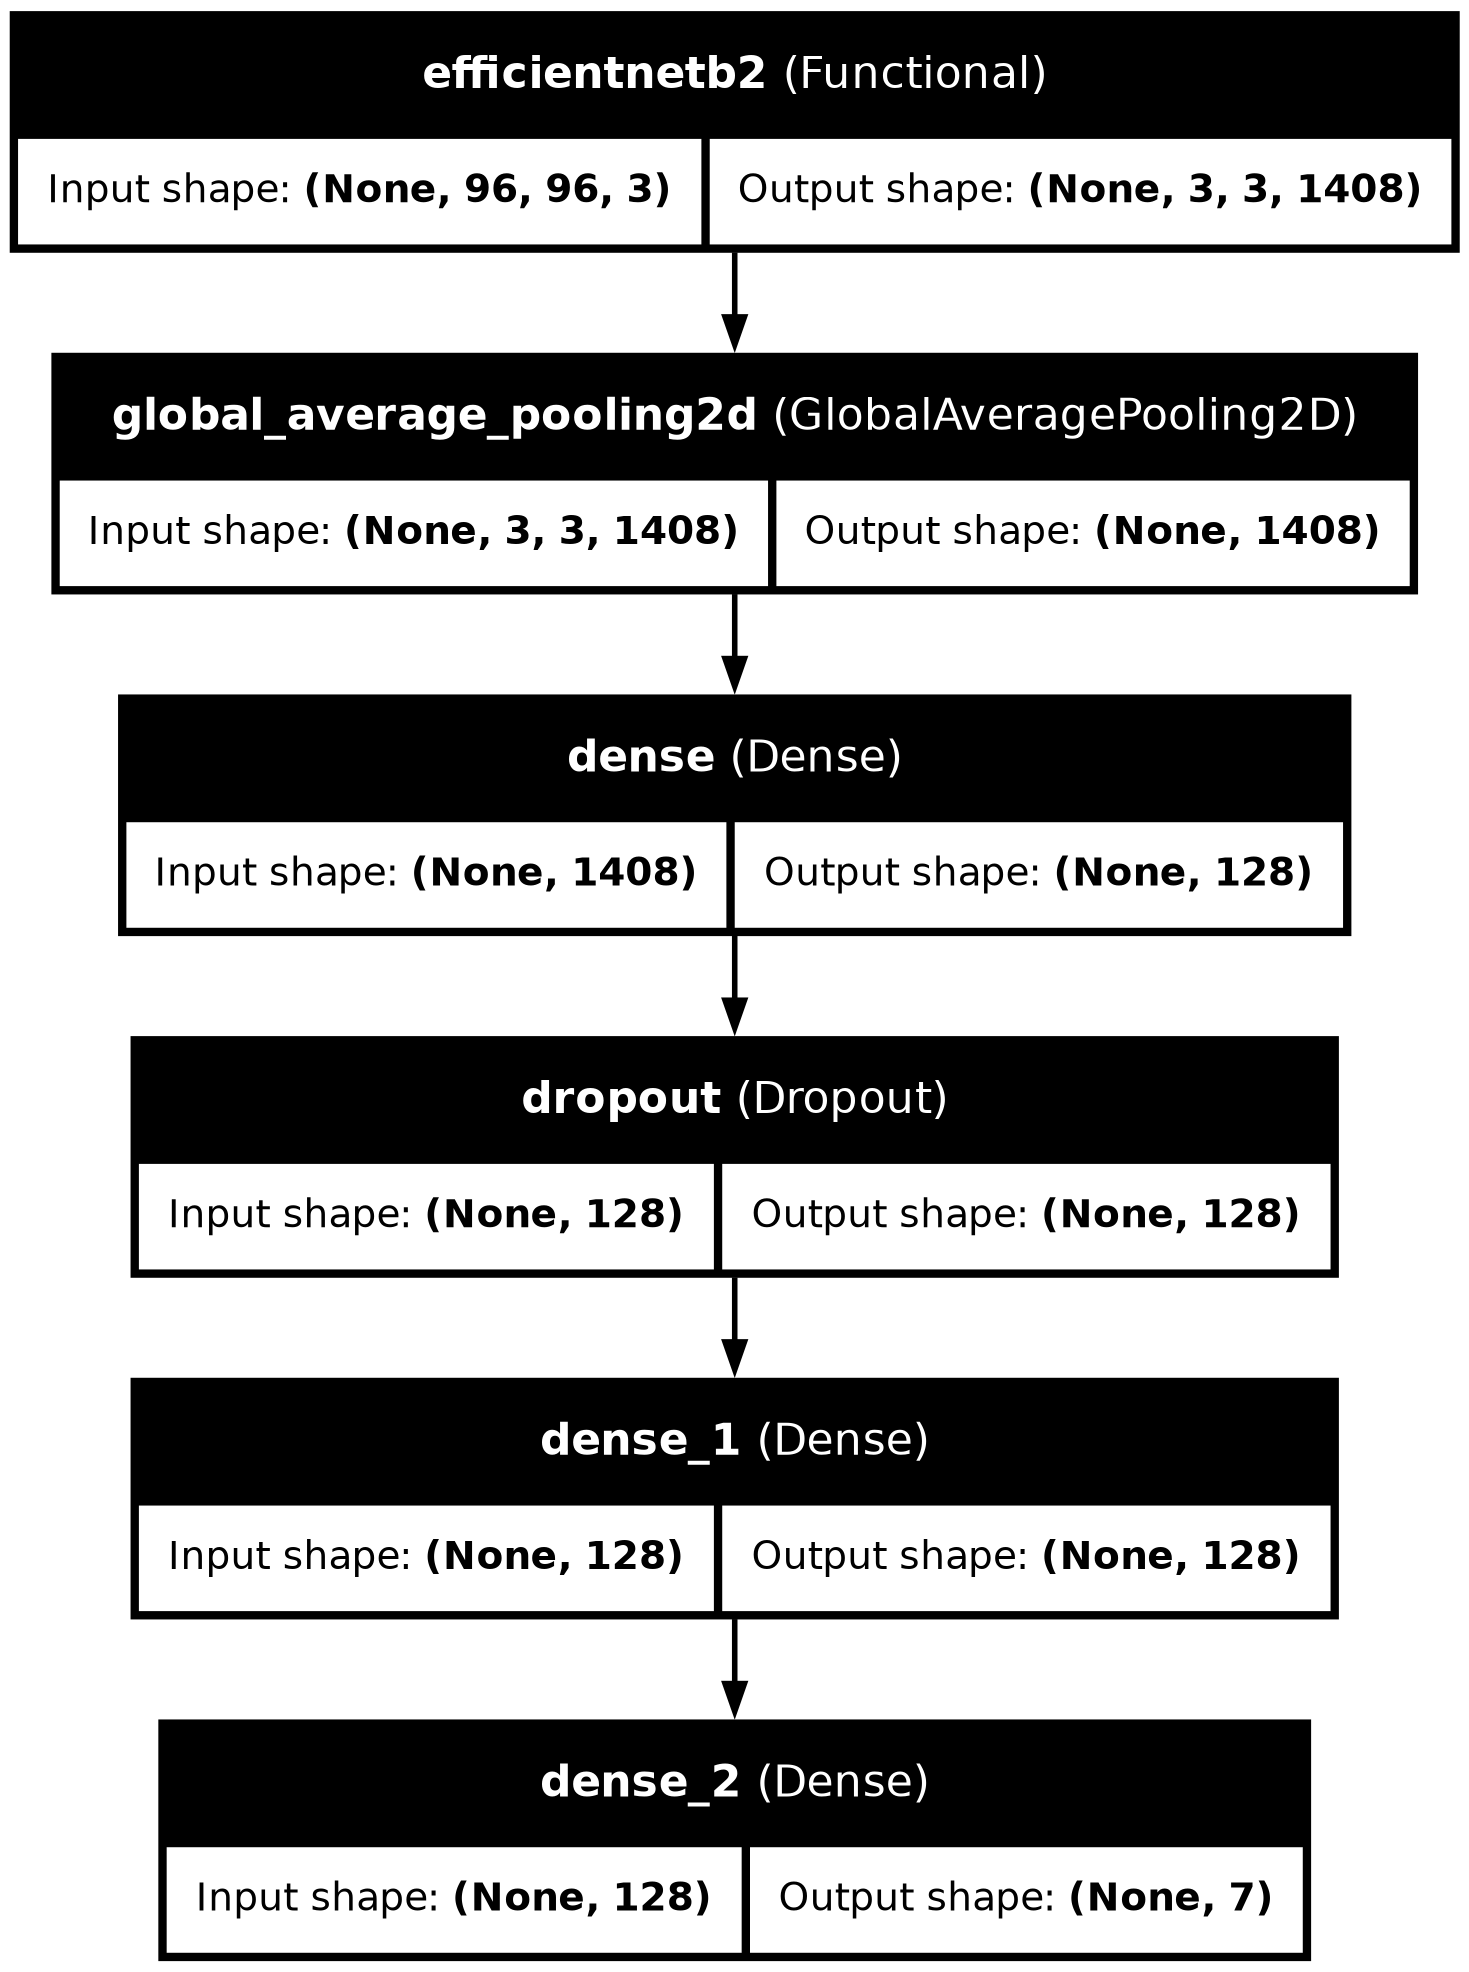

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

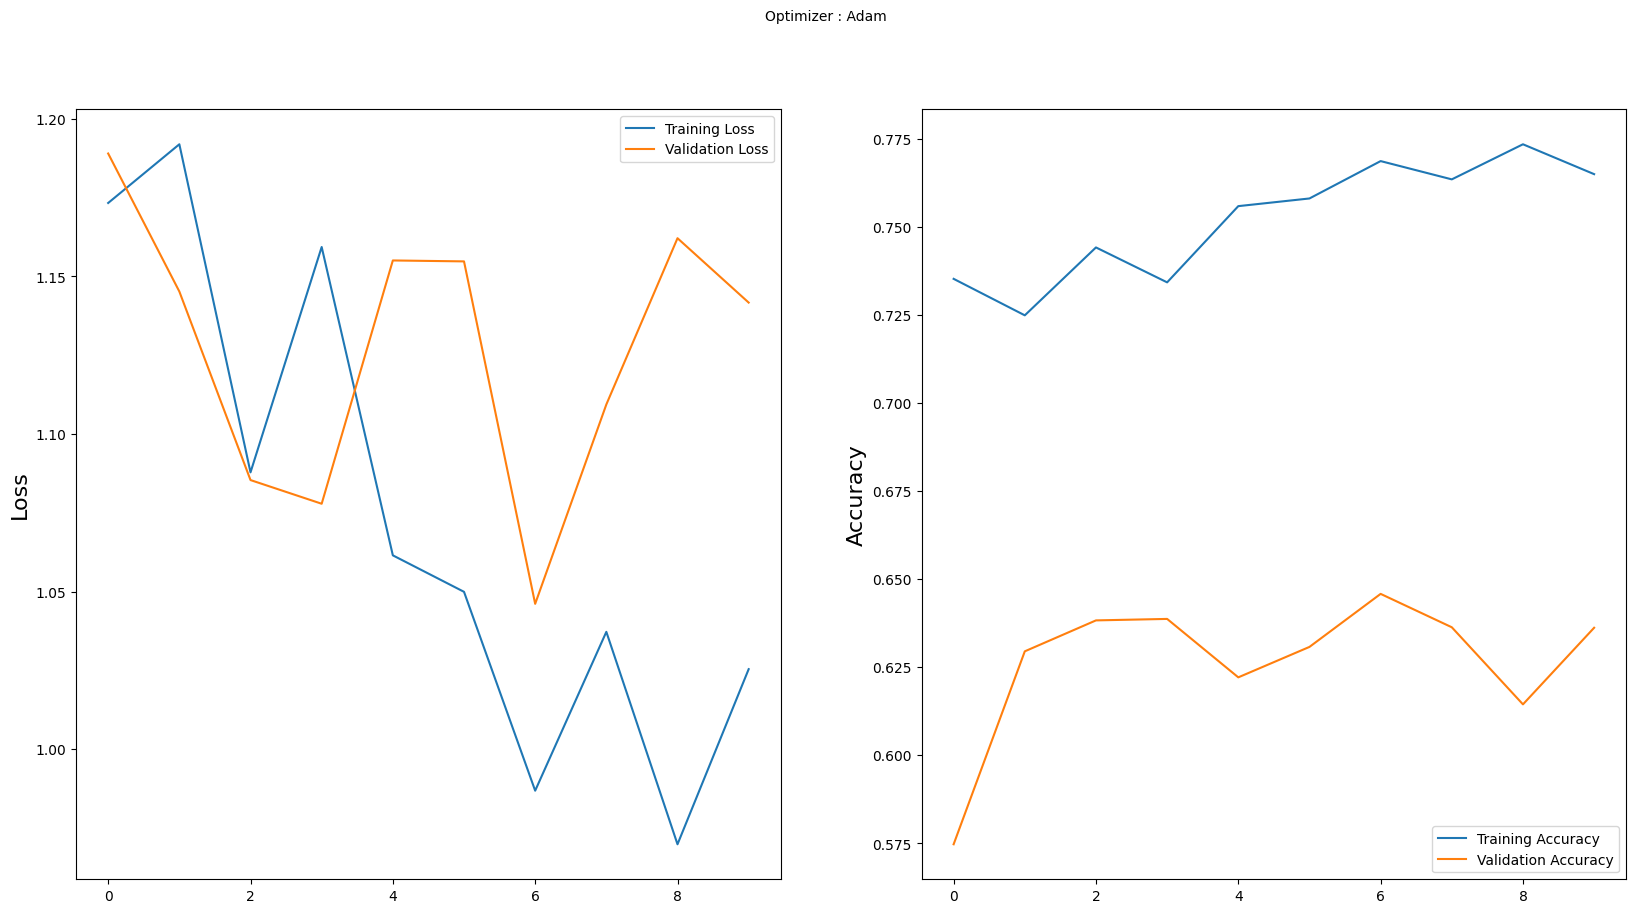

In [20]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
 

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
 
plt.show()

In [21]:
model.load_weights("best_weights.weights.h5")

## Test

In [22]:
from pathlib import Path

# Define the path to the test directory
test_dir = Path('/kaggle/input/face-expression-recognition-dataset/images/validation')

# List all files in the test directory
files = list(test_dir.glob("*/*"))



In [23]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation

 
test_image_paths = list(map(lambda x : str(x) , files))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [24]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


surprise


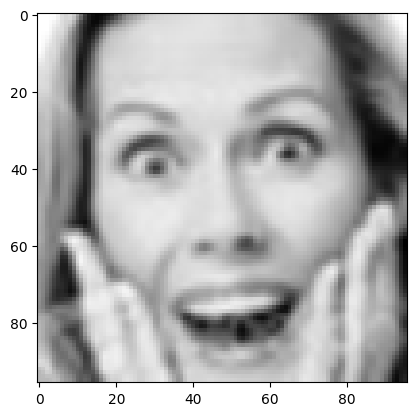

In [25]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [26]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.6103 - loss: 1.2168 - precision: 0.6679 - recall: 0.5547
 Testing Acc :  0.6433625817298889
 Testing Precision  0.7058924436569214
 Testing Recall  0.5832154154777527


W0000 00:00:1718699040.495992      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
# compute predictions
predictions = model.predict(test_dataset)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = np.argmax(test_labels,axis=1)
class_names =  Le.inverse_transform(y_pred)

 10/221 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

W0000 00:00:1718699053.623746      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step


W0000 00:00:1718699063.693797      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


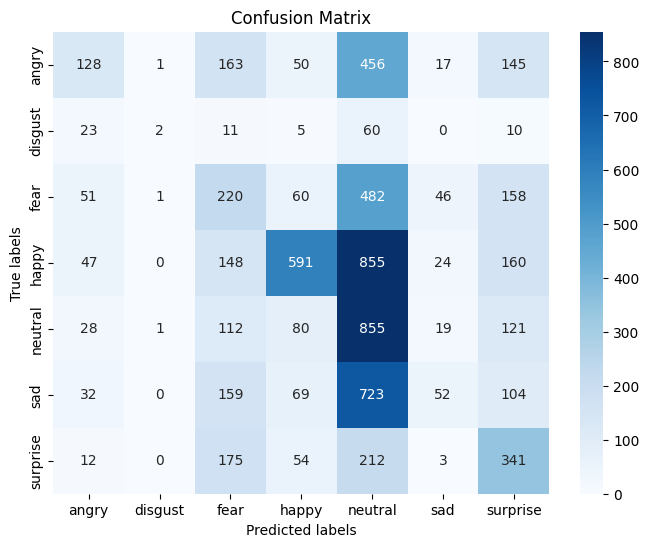

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=Le.classes_, yticklabels=Le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Save objects

In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("final_best_weights.weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)


In [30]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [31]:
save_object(Le, "LabelEncoder")

## Inference Test Using New image

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained face cascade classifier for detect face boundries
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")



def detect_image_emotion(image_path):
    # Read the input image
    img = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=25)

    # Check if any faces were detected
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Adjust ROI coordinates to avoid going out of bounds
            x = max(0, x)
            y = max(0, y)
            face = img[y:y+h+150, x:x+w+150]   
            face = cv2.resize(face, (96, 96))
            face_array = np.array(face)
            face_array = np.expand_dims(face_array, axis=0)
            prediction = np.argmax(model.predict([face_array]), axis=1)
            class_ = Le.inverse_transform(prediction)[0]
            font = cv2.FONT_HERSHEY_SIMPLEX
            print(class_)
            cv2.putText(img, class_, (x, y), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else:
        print("No faces detected in the image.")

    # Display the modified image using matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
neutral


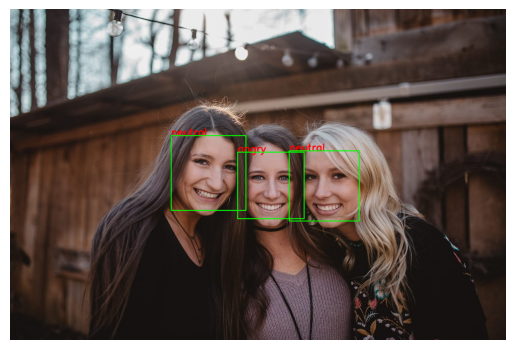

In [33]:
detect_image_emotion("/kaggle/input/human-faces-object-detection/images/00000715.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
happy


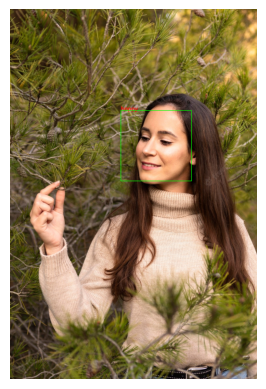

In [34]:
 detect_image_emotion("/kaggle/input/human-faces-object-detection/images/00000100.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
surprise


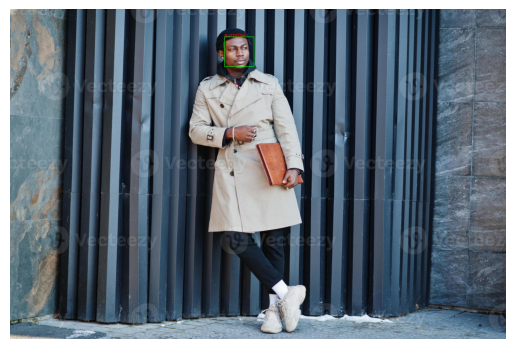

In [35]:
 detect_image_emotion("/kaggle/input/human-faces-object-detection/images/00000957.jpg")